<a href="https://colab.research.google.com/github/MInner/lrmf/blob/main/tfp_digits_glow_fails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

tfd = tfp.distributions
tfb = tfp.bijectors

VISIBLE_GPU_ID = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
assert len(gpus) == 3, 'you should run it locally'
tf.config.experimental.set_visible_devices(gpus[VISIBLE_GPU_ID], 'GPU')
print(len(gpus), tf.config.experimental.list_logical_devices('GPU'))

In [ ]:
import torchvision
from torchvision.datasets.utils import download_url
from torchvision import transforms
import itertools

def show_panel(arr, n=10, **kwargs):
  fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
  for i, ax in enumerate(axes):
    ax.imshow(arr[i][..., 0], **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
  
  plt.show()

[((60000, 32, 32, 1), dtype('float32'), 0.0, 1.0), ((7291, 32, 32, 1), dtype('float32'), 0.0, 0.99607843)]


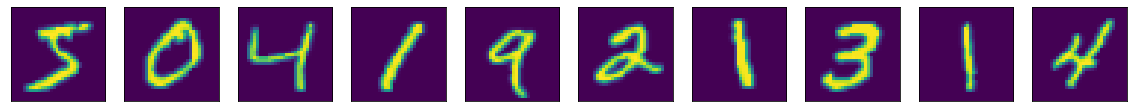

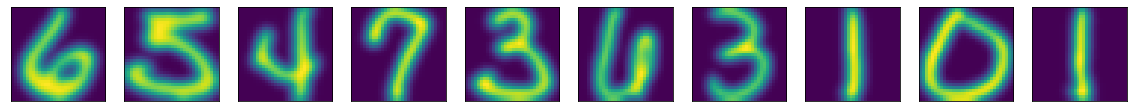

In [ ]:
torchvision.datasets.mnist.MNIST.resources = [
    ("https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
    ("https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
    ("https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
    ("https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
]

img_size = 32
img_shape = (img_size, img_size, 1)
resize = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])
usps_tv_dataset = torchvision.datasets.usps.USPS('.', download=True, transform=resize)
usps_array = np.array([pair[0].numpy()[0] for pair in usps_tv_dataset])
mnist_tv_dataset = torchvision.datasets.mnist.MNIST('.', download=True, transform=resize)
mnist_array = np.array([pair[0].numpy()[0] for pair in mnist_tv_dataset])
mnist_array, usps_array = mnist_array[..., None], usps_array[..., None]
# mnist_array, usps_array = [(x*2 - 1.0) for x in [mnist_array, usps_array]]
print([(x.shape, x.dtype, x.min(), x.max()) for x in [mnist_array, usps_array]])

show_panel(mnist_array)
show_panel(usps_array)

mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_array)
usps_dataset = tf.data.Dataset.from_tensor_slices(usps_array)

In [ ]:
def shorten_id(name):
  return name if len(name) < 40 else ('s' + str(hash(name)) + name[-20:])

if tf.name_scope.__name__.endswith('v2'):
  real_tf_name_scope = tf.name_scope
  tf.name_scope = lambda name: real_tf_name_scope(shorten_id(name))

In [ ]:
import sys
our_code_path = '/home/grad2/usmn/projects/lrmf/code'
if our_code_path not in sys.path:
  sys.path.append(our_code_path)

import lrmf

## Initialize T from pre-trained model_a model_b and fix

In [ ]:
from functools import partial

img_shape = (img_size, img_size, 1)
mnist_dataset_aug = mnist_dataset.map(partial(lrmf.add_two_sided_noise_aug, level=0.05))
usps_dataset_aug = usps_dataset.map(partial(lrmf.add_two_sided_noise_aug, level=0.05))

In [ ]:
def build_glow_translation_model_from_ab(shape, model_a, model_b):
  base_distribution = tfd.MultivariateNormalDiag(
        loc=tf.zeros(np.prod(shape)),
        scale_diag=tf.ones(np.prod(shape)))

  base_resh_dist = tfd.TransformedDistribution(
    distribution=base_distribution,
    bijector=tfp.bijectors.Reshape(event_shape_out=shape,
                                   event_shape_in=[np.prod(shape)]),
  )

  model_b_inv = model_b.bijector._bijector  # because it is inverse already
  flow = lrmf.ForwardChain([model_b_inv, model_a.bijector])

  glow_t_dist = tfd.TransformedDistribution(
      distribution=base_resh_dist,
      bijector=flow)

  return glow_t_dist

model_a = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)
model_b = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)
print(model_a.log_prob(mnist_array[:4]), model_b.log_prob(mnist_array[:4]))

tf.Tensor([506.75317 505.8496  668.9182  758.474  ], shape=(4,), dtype=float32) tf.Tensor([479.80127 467.05103 653.9165  711.9795 ], shape=(4,), dtype=float32)


restoring ['model'] : /scratch2/run/lrmf/mnist32_3_8/ckpt/ckpt-560
restoring ['model'] : /scratch2/run/lrmf/usps32_3_8/ckpt/ckpt-295


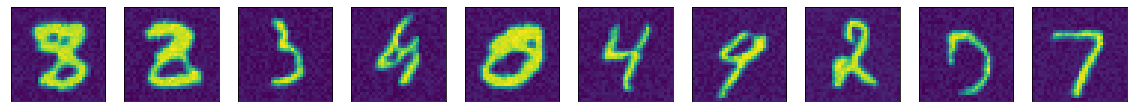

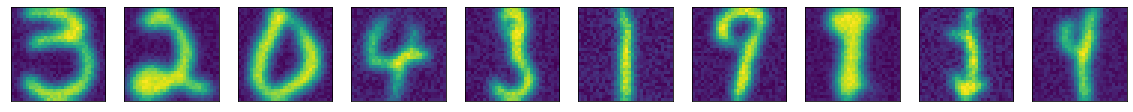

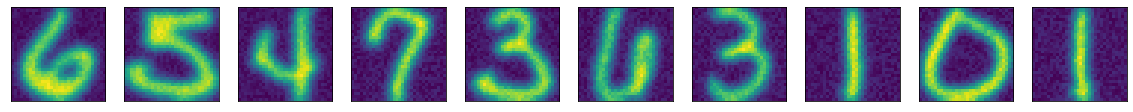

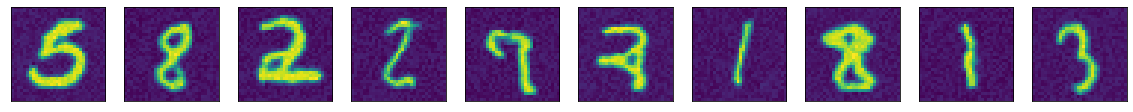

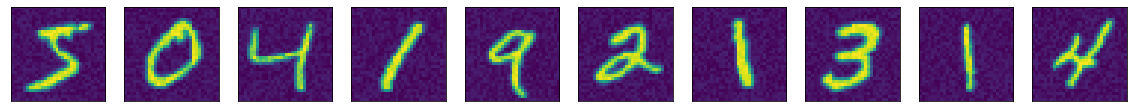

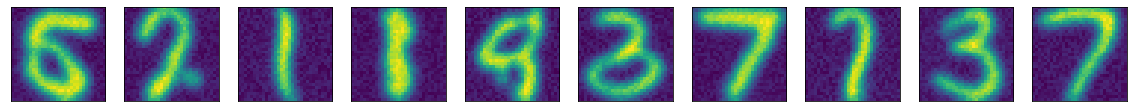

In [ ]:
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/mnist32_3_8/ckpt', model=model_a)
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/usps32_3_8/ckpt',  model=model_b)
model_t = build_glow_translation_model_from_ab(img_shape, model_a, model_b)

show_panel(model_a.sample(16))
show_panel(model_b.sample(16))

batch_a = next(iter(mnist_dataset_aug.batch(16)))
batch_b = next(iter(usps_dataset_aug.batch(16)))
show_panel(batch_b)
show_panel(model_t.bijector.forward(batch_b))

show_panel(batch_a)
show_panel(model_t.bijector.inverse(batch_a))

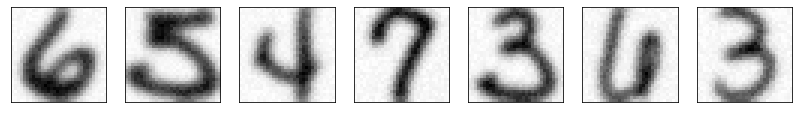

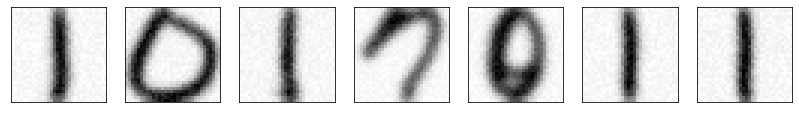

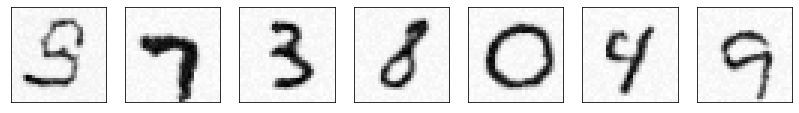

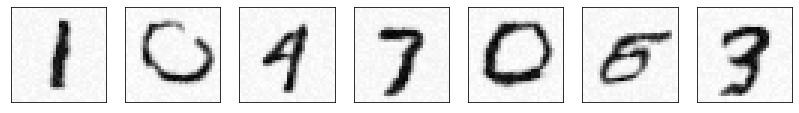

In [ ]:
show_panel(batch_b[:7], n=7, cmap='Greys')
show_panel(batch_b[7:14], n=7, cmap='Greys')
show_panel(model_t.bijector.forward(batch_b[:7]), n=7, cmap='Greys')
show_panel(model_t.bijector.forward(batch_b[7:14]), n=7, cmap='Greys')

In [ ]:
def tqdm_tfd(dataset, **kwargs):
  return tqdm.tqdm(dataset, total=int(tf.data.experimental.cardinality(dataset)), **kwargs)

In [ ]:
tf.data.experimental.cardinality(mnist_dataset_aug.batch(32).shuffle(1024).take(10))

<tf.Tensor: shape=(), dtype=int64, numpy=10>

In [ ]:
batch_size = 128
nlls = [-1*tf.reduce_mean(list(map(model.log_prob, tqdm_tfd(
            dataset.batch(batch_size).shuffle(100).take(10)
        )))) for dataset, model 
        in zip([mnist_dataset_aug, usps_dataset_aug], [model_a, model_b])]

# nlls = [-2035, -2146]
print(nlls)


[<tf.Tensor: shape=(), dtype=float32, numpy=-2094.7449>, <tf.Tensor: shape=(), dtype=float32, numpy=-2185.2822>]


In [ ]:
# model_a = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)
# model_b = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)

In [ ]:
# batch_size = 32

# lrmf.fit_density_model(model_a, mnist_dataset_aug.batch(batch_size), 
#                       lr=1e-5, epochs=50,
#                       show_every=100, print_every=100, save_every=1000, clf_every=5000,
#                       run_path='/scratch2/run/lrmf/mnist32_3_8/',
#                       domain_clf_builder=partial(lrmf.build_domain_classifier, verbose=True),
#                       compile=True)

# lrmf.fit_density_model(model_b, usps_dataset_aug.batch(batch_size), 
#                       lr=1e-5, epochs=100,
#                       show_every=100, print_every=100, save_every=1000, clf_every=5000,
#                       run_path='/scratch2/run/lrmf/usps32_3_8/',
#                       domain_clf_builder=partial(lrmf.build_domain_classifier, verbose=True),
#                       compile=True)

In [ ]:
# dataset_stats = lrmf.compute_dataset_stats(model_t.distribution, usps_dataset_aug, *nlls)
dataset_stats = {'const': -5294.1074, 'prior': -1014.08, 'nll_a': -2094.7449, 'nll_b': -2185.2822}
print(dataset_stats)

{'const': -5294.1074, 'prior': -1014.08, 'nll_a': -2094.7449, 'nll_b': -2185.2822}


In [ ]:
def tfds_batch_map(fn, dataset, batch_size, tqdm=True):
  maybe_tqdm = tqdm_tfd if tqdm else lambda x: x
  return tf.data.Dataset.from_tensor_slices(np.concatenate(list(map(
    lambda x: fn(x).numpy(), maybe_tqdm(dataset.batch(batch_size))))))

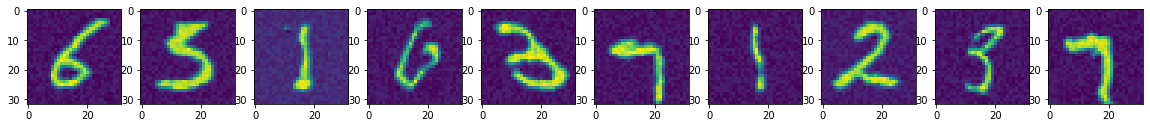

In [ ]:
# mapped_dataset = tf.data.Dataset.from_tensor_slices(np.concatenate(list(map(
#     lambda x: model_t.bijector.forward(x).numpy(), 
#     tqdm_tfd(usps_dataset_aug.batch(128))))))

mapped_dataset = tfds_batch_map(model_t.bijector.forward, usps_dataset_aug, 128)

show_panel(list(mapped_dataset.take(16)))
serialized_dataset = mapped_dataset.map(tf.io.serialize_tensor)
fn = '/scratch2/run/lrmf/mnist32_3_8/data/usps2mnist_better.tfrecord'
writer = tf.data.experimental.TFRecordWriter(fn)
writer.write(serialized_dataset)

In [ ]:
a2b_nll = -1*tf.reduce_mean([
  model_a.log_prob(model_t.bijector.forward(x)) 
  for x in tqdm_tfd(usps_dataset_aug.batch(32).shuffle(100).take(20))
])

sampled_nll = -1*tf.reduce_mean([
  model_a.log_prob(model_a.sample(32)) 
  for _ in tqdm.trange(20)
])

print(a2b_nll, sampled_nll)


tf.Tensor(-2083.1804, shape=(), dtype=float32) tf.Tensor(-2095.2554, shape=(), dtype=float32)


In [ ]:
model_s = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)
print(model_s.log_prob(mnist_array[:4]))
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/mnist32_3_8/ckpt', model=model_s)
print(model_s.log_prob(mnist_array[:4]))

tf.Tensor([565.9136  534.80444 674.77905 846.6565 ], shape=(4,), dtype=float32)
restoring ['model'] : /scratch2/run/lrmf/mnist32_3_8/ckpt/ckpt-560
tf.Tensor([2189.9058 2193.2588 2233.249  2303.5037], shape=(4,), dtype=float32)


In [ ]:
batch_size = 4

lrmf.fit_lrmf_model(model_s, model_t,
                    mnist_dataset_aug.batch(batch_size), usps_dataset_aug.batch(batch_size), 
                    dataset_stats=dataset_stats, lr=1e-6, pretrain_t=None,
                    print_every=10, show_every=50, clf_every=2000, save_every=1000,
                    run_path='/scratch2/run/lrmf/actual_lrmf/digits_best_init5_1e6',
                    #  eq_mean_reg_lam=1000.0,
                    domain_clf_builder=partial(lrmf.build_domain_classifier, verbose=True),
                    domain_clf_size=1024,
                    show_panel=show_panel,
                    compile=True)

In [ ]:
model_t = lrmf.build_glow_translation_model(img_shape, levels=4, level_depth=4)
print(model_t.bijector.bijectors[1].forward(mnist_array[:4]).shape)
print(model_t.bijector.bijectors[0].inverse(mnist_array[:4]).shape)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Creating pad 1_1_18_18
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Creating pad 1_1_10_10
Creating pad 1_1_6_6
Creating pad 1_1_4_4
(4, 32, 32, 1)
(4, 32, 32, 1)


In [ ]:
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/actual_lrmf/digits_best_init2/ckpt',  model_t=model_t)

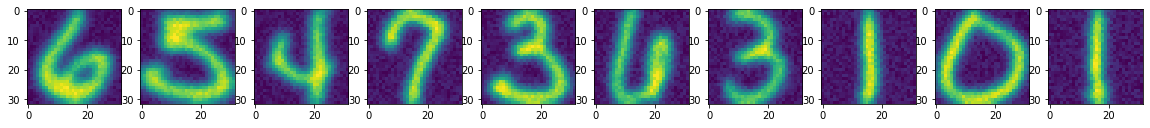

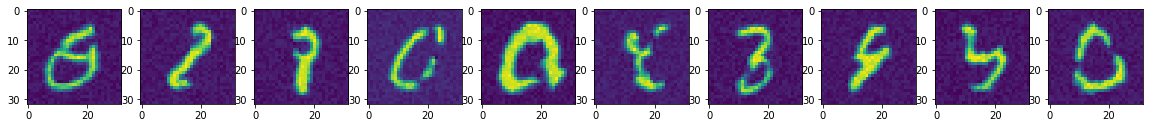

In [ ]:
batch_b = next(iter(usps_dataset_aug.batch(16)))
show_panel(batch_b)
show_panel(model_t.bijector.forward(batch_b))

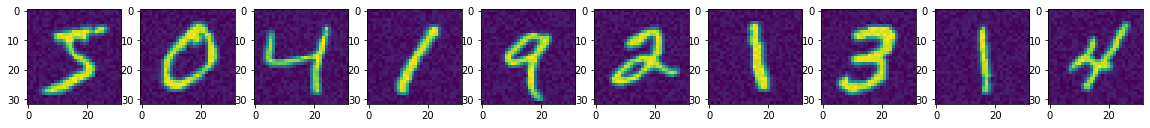

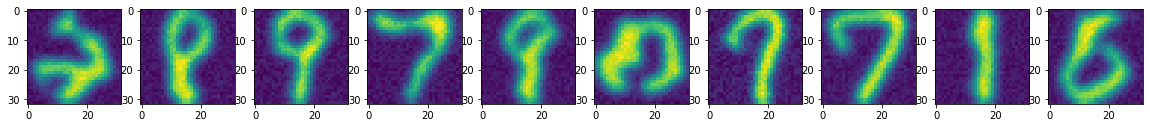

In [ ]:
batch_a = next(iter(mnist_dataset_aug.batch(16)))
show_panel(batch_a)
show_panel(model_t.bijector.inverse(batch_a))

In [ ]:
loss_arr = np.array([list(map(float, lrmf.lrmf_loss(model_a, model_t, batch_a, batch_b)))
                     for batch_a, batch_b 
                     in tqdm_tfd(tf.data.Dataset.zip((mnist_dataset_aug, usps_dataset_aug)).batch(32).take(20))])

In [ ]:
mean_losses = list(map(float, np.mean(loss_arr, axis=0)))
print(mean_losses)

[-2037.5660278320313, -2033.8943908691406, -1122.8511596679687, 0.06865591891109943]


In [ ]:
print('shared A loss', mean_losses[0])
print('private A loss', nlls[0])
print('shared T(B) loss', mean_losses[1])
print('private T(B) loss estimate', mean_losses[2] - dataset_stats['prior'] + nlls[1])
print('private B loss', nlls[1])

shared A loss -2037.5660278320313
private A loss -2035
shared T(B) loss -2033.8943908691406
private T(B) loss estimate -2254.7723022460937
private B loss -2146


In [ ]:
loss_arr = tfds_batch_map(lambda batch: tf.convert_to_tensor(lrmf.lrmf_loss(model_a, model_t, *batch)),
                          tf.data.Dataset.zip((mnist_dataset_aug, usps_dataset_aug)),
                          batch_size=128)

In [ ]:
print(list(map(float, np.array(list(loss_arr.as_numpy_iterator())).reshape(-1, 4).mean(axis=0))))

[-2093.9853515625, -2084.185302734375, -1114.7496337890625, 0.018979379907250404]


In [ ]:
zip_tfd = tf.data.Dataset.zip

batch_size = 128
take_batches = 50
prior_b = -1014.07324

nlls = [-1*tf.reduce_mean(list(map(model.log_prob, tqdm_tfd(
            dataset.batch(batch_size, drop_remainder=True).take(take_batches)
        )))) for dataset, model 
        in zip([mnist_dataset_aug, usps_dataset_aug], [model_a, model_b])]

loss_arr = np.array([list(map(float, lrmf.lrmf_loss(model_a, model_t, batch_a, batch_b)))
                     for batch_a, batch_b 
                     in tqdm_tfd(
                         zip_tfd((mnist_dataset_aug, usps_dataset_aug))
                         .batch(batch_size, drop_remainder=True).take(take_batches)
                        )
                     ])




shared A loss (acutally for model_s = model_a) -2037.5660278320313
private A loss tf.Tensor(-2036.75, shape=(), dtype=float32)
shared T(B) loss (acutally for model_s = model_a) -2033.8943908691406
private T(B) loss estimate via flow tf.Tensor(-2252.3503, shape=(), dtype=float32)
private B loss tf.Tensor(-2143.5781, shape=(), dtype=float32)
nnls [<tf.Tensor: shape=(), dtype=float32, numpy=-2036.75>, <tf.Tensor: shape=(), dtype=float32, numpy=-2143.5781>]


In [ ]:
mean_losses = list(map(float, np.array(list(loss_arr.as_numpy_iterator())).reshape(-1, 4).mean(axis=0)))

print('shared A loss (acutally for model_s = model_a)', mean_losses[0])
print('private A loss', nlls[0])
print('shared T(B) loss (acutally for model_s = model_a)', mean_losses[1])
print('private T(B) loss estimate via flow', -mean_losses[2] + dataset_stats['prior'] + nlls[1])
print('private B loss', nlls[1])

print('nnls', nlls)

shared A loss (acutally for model_s = model_a) -2093.9853515625
private A loss tf.Tensor(-2094.7449, shape=(), dtype=float32)
shared T(B) loss (acutally for model_s = model_a) -2084.185302734375
private T(B) loss estimate via flow tf.Tensor(-2084.6125, shape=(), dtype=float32)
private B loss tf.Tensor(-2185.2822, shape=(), dtype=float32)
nnls [<tf.Tensor: shape=(), dtype=float32, numpy=-2094.7449>, <tf.Tensor: shape=(), dtype=float32, numpy=-2185.2822>]


In [ ]:
!ls /scratch2/run/lrmf/mnist32_3_8/data/usps2mnist_better.tfrecord

/scratch2/run/lrmf/mnist32_3_8/data/usps2mnist_better.tfrecord


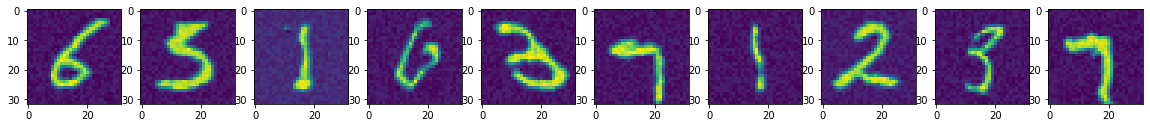

In [ ]:
def tf_record_tensor_dataset(fn, shape):
  str_ds = tf.data.TFRecordDataset([fn])
  tensor_ds = str_ds.map(lambda s: tf.io.parse_tensor(s, tf.float32))
  reshaped_ds = tensor_ds.map(lambda x: (x.set_shape(shape), x)[1])
  return reshaped_ds

a2b_dataset = tf_record_tensor_dataset('/scratch2/run/lrmf/mnist32_3_8/data/usps2mnist_better.tfrecord', (32, 32, 1))
show_panel(list(a2b_dataset.take(16)))

In [ ]:
batch_size = 32

lrmf.fit_density_model(model_s, a2b_dataset.batch(batch_size), 
                       lr=1e-5, epochs=400,
                       show_every=100, print_every=100, save_every=1000, clf_every=5000,
                       run_path='/scratch2/run/lrmf/mnist_a2b_actual_3_8/',
                       domain_clf_builder=partial(lrmf.build_domain_classifier, verbose=True),
                       compile=True)

init loss tf.Tensor(-2174.706, shape=(), dtype=float32)
restoring from  /scratch2/run/lrmf/mnist_a2b_actual_3_8/ckpt/ckpt-22
restored step = 22000
{'data': {'shape': (32, 32, 32, 1)},
 'model': {'factor': 2,
           'glow_step_args': {'actnorm_scale_norm_bijector': 'softplus_p2_scale',
                              'filters': 512,
                              'kernel_size': (3, 3),
                              'normalization': 'actnorm',
                              'nvp_scale_norm_bijector': 'sigmoid_p2_scale',
                              'resnet_depth': 2,
                              'shift_scale_fn_builder': 'glow_conv_net_template_tf1'},
           'level': 3,
           'level_depth': 8},
 'opt': {'amsgrad': False,
         'beta_1': 0.9,
         'beta_2': 0.999,
         'decay': 0.0,
         'epsilon': 1e-07,
         'learning_rate': 1e-05,
         'name': 'Adam'}}


22000 -2168.700 4.945
22100 -2162.094 4.954
22200 -2150.637 4.970
22300 -2174.333 4.937
22400 -2155.438 4.963
22500 -2170.580 4.942
22600 -2165.591 4.949
22700 -2151.099 4.969
22800 -2148.551 4.973
22900 -2155.536 4.963
23000 -2173.026 4.938
saving step = 23000 to /scratch2/run/lrmf/mnist_a2b_actual_3_8/ckpt
saved as /scratch2/run/lrmf/mnist_a2b_actual_3_8/ckpt/ckpt-23
23100 -2156.750 4.961
23200 -2166.083 4.948
23300 -2182.620 4.925
23400 -2154.305 4.965
23500 -2161.553 4.955
23600 -2140.375 4.984
23700 -2160.894 4.956
23800 -2157.717 4.960
23900 -2168.588 4.945
24000 -2164.022 4.951
saving step = 24000 to /scratch2/run/lrmf/mnist_a2b_actual_3_8/ckpt
saved as /scratch2/run/lrmf/mnist_a2b_actual_3_8/ckpt/ckpt-24
24100 -2155.811 4.963
24200 -2156.442 4.962
24300 -2161.518 4.955
24400 -2155.729 4.963
24500 -2165.677 4.949
24600 -2173.115 4.938
24700 -2152.774 4.967
24800 -2165.865 4.949
24900 -2151.721 4.968
25000 -2164.477 4.951
Epoch 1/50
62/62 [==============================] - 1s 10m

In [ ]:
print(tf.reduce_mean(model_t.bijector.forward_log_det_jacobian(batch_b, event_ndims=3)))

tf.Tensor(91.9879, shape=(), dtype=float32)


In [ ]:
print(tf.reduce_mean(model_t.log_prob(model_t.bijector.forward(batch_b))), dataset_stats['prior'])

tf.Tensor(-1094.3805, shape=(), dtype=float32) -1014.08


In [ ]:
import lrmf_fj

tf.Tensor([453.7329  467.79077 669.0801  810.4719 ], shape=(4,), dtype=float32) tf.Tensor([510.12988 503.1709  715.8439  797.4463 ], shape=(4,), dtype=float32)
restoring ['model'] : /scratch2/run/lrmf/mnist32_3_8/ckpt/ckpt-560
restoring ['model'] : /scratch2/run/lrmf/usps32_3_8/ckpt/ckpt-295


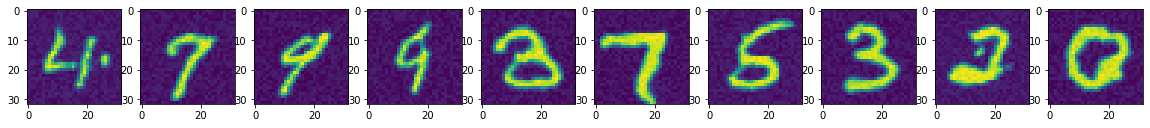

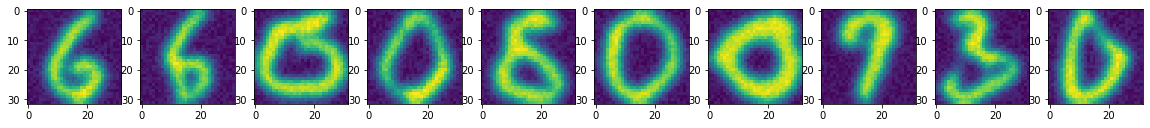

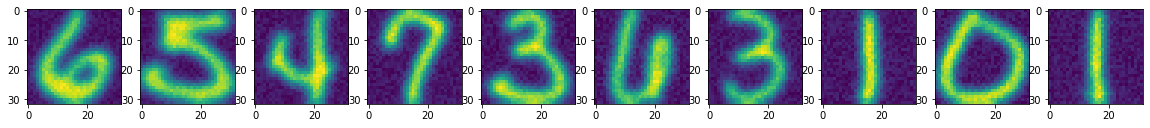

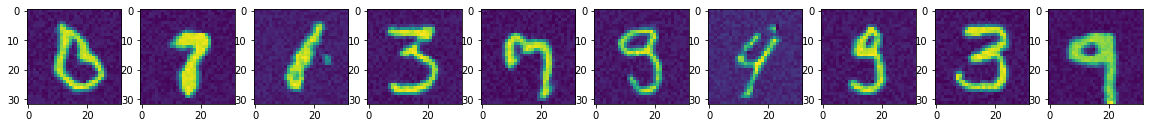

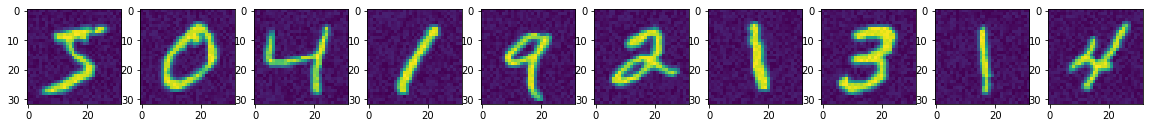

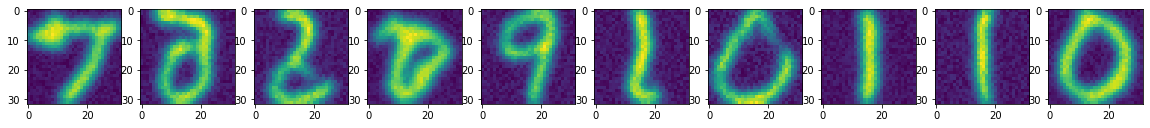

tf.Tensor([596.1699  567.80383 741.6151  855.5924 ], shape=(4,), dtype=float32)
restoring ['model'] : /scratch2/run/lrmf/mnist32_3_8/ckpt/ckpt-560
tf.Tensor([2189.9058 2193.2588 2233.249  2303.5037], shape=(4,), dtype=float32)


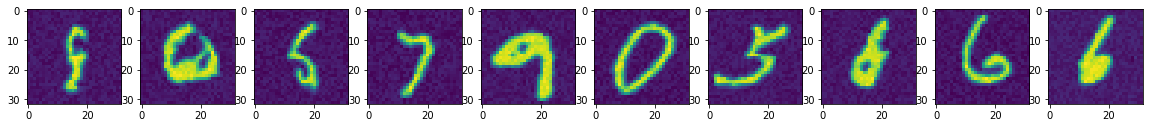

In [ ]:
model_a = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)
model_b = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)
print(model_a.log_prob(mnist_array[:4]), model_b.log_prob(mnist_array[:4]))

lrmf.ckpt_restore_latest('/scratch2/run/lrmf/mnist32_3_8/ckpt', model=model_a)
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/usps32_3_8/ckpt',  model=model_b)
model_t = build_glow_translation_model_from_ab(img_shape, model_a, model_b)

show_panel(model_a.sample(16))
show_panel(model_b.sample(16))

batch_a = next(iter(mnist_dataset_aug.batch(16)))
batch_b = next(iter(usps_dataset_aug.batch(16)))
show_panel(batch_b)
show_panel(model_t.bijector.forward(batch_b))

show_panel(batch_a)
show_panel(model_t.bijector.inverse(batch_a))

model_s = lrmf.build_deep_conv_glow(img_shape, levels=3, level_depth=8)
print(model_s.log_prob(mnist_array[:4]))
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/mnist32_3_8/ckpt', model=model_s)
print(model_s.log_prob(mnist_array[:4]))
show_panel(model_s.sample(16))

dataset_stats = {'const': -5294.1074, 'prior': -1014.08, 'nll_a': -2094.7449, 'nll_b': -2185.2822}

In [ ]:
import imp
import lrmf_fj
imp.reload(lrmf_fj)

<module 'lrmf_fj' from '/home/grad2/usmn/projects/lrmf/code/lrmf_fj.py'>

(4, 32, 32, 1)
(4, 32, 32, 1)
(8, 32, 32, 1)


/scratch/bin/anc3/envs/tf2py37/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/scratch/bin/anc3/envs/tf2py37/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/scratch/bin/anc3/envs/tf2py37/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/scratch/bin/anc3/envs/tf2py37/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/scratch/bin/anc3/envs/tf2py37/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


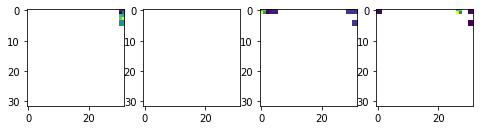

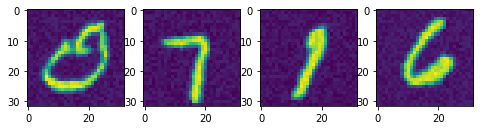

init pre-init {'total_loss': <tf.Tensor: shape=(), dtype=float32, numpy=12.049316>, 'nll_s_a': <tf.Tensor: shape=(), dtype=float32, numpy=-2093.359>, 'nll_s_t': <tf.Tensor: shape=(), dtype=float32, numpy=-2112.8604>, 'neg_fwd_jac': <tf.Tensor: shape=(), dtype=float32, numpy=-61.75891>, 'eq_mean_reg': <tf.Tensor: shape=(), dtype=float32, numpy=0.4955755>, 'fwd_jac_var': <tf.Tensor: shape=(), dtype=float32, numpy=8726.436>, 'const': <tf.Tensor: shape=(), dtype=float32, numpy=4280.0273>}
loss post pre-train b {'total_loss': <tf.Tensor: shape=(), dtype=float32, numpy=12.049316>, 'nll_s_a': <tf.Tensor: shape=(), dtype=float32, numpy=-2093.359>, 'nll_s_t': <tf.Tensor: shape=(), dtype=float32, numpy=-2112.8604>, 'neg_fwd_jac': <tf.Tensor: shape=(), dtype=float32, numpy=-61.75891>, 'eq_mean_reg': <tf.Tensor: shape=(), dtype=float32, numpy=0.4955755>, 'fwd_jac_var': <tf.Tensor: shape=(), dtype=float32, numpy=8726.436>, 'const': <tf.Tensor: shape=(), dtype=float32, numpy=4280.0273>}


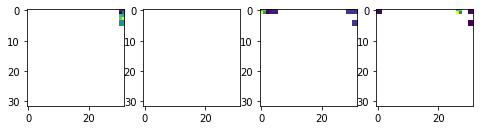

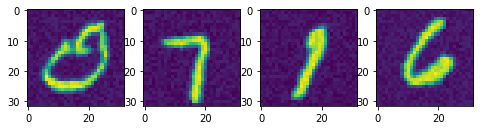

saving tensorboard logs to  /scratch2/run/lrmf/actual_lrmf/digits_fixed_fj_reg_1e6/logs/20200506-160317
Epoch 1/50
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0255 - accuracy: 0.9933 - val_loss: 1.8353 - val_accuracy: 0.7266
Epoch 2/50
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0305 - accuracy: 0.9930 - val_loss: 1.5477e-04 - val_accuracy: 1.0000
Epoch 3/50
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0206 - accuracy: 0.9947 - val_loss: 3.5916e-06 - val_accuracy: 1.0000
Epoch 4/50
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0149 - accuracy: 0.9966 - val_loss: 8.9799e-09 - val_accuracy: 1.0000
Epoch 5/50
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0132 - accuracy: 0.9968 - val_loss: 1.5537e-08 - val_accuracy: 1.0000
Epoch 6/50
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0132 - accuracy: 0.9966 - val_loss: 4.8388e-04 - val_accuracy: 1.0000
Epoch 7/50
1

    0 total_loss = 14.629 nll_s_a = -2098.498 nll_s_t = -2080.893 neg_fwd_jac = -86.008 eq_mean_reg = 0.486 fwd_jac_var = 2781.304 const = 4280.027 bpd_a = 5.043 bpd_b = 5.068 nll_p/tb_est = -2099.275 nll_p/a = -2094.745 zm/nll_s_a = -3.753 zm/nll_s_tb = 13.852 gap/tb_est = 18.382 gap/a = -3.753
Epoch 1/50
30/30 [==============================] - 1s 22ms/step - loss: 0.6866 - accuracy: 0.5469 - val_loss: 0.6769 - val_accuracy: 0.6094
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6790 - accuracy: 0.5578 - val_loss: 0.6692 - val_accuracy: 0.6094
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6709 - accuracy: 0.5880 - val_loss: 0.6673 - val_accuracy: 0.6172
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6751 - accuracy: 0.5885 - val_loss: 0.6583 - val_accuracy: 0.6016
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6698 - accuracy: 0.5844 - val_loss: 0.6621 - val_accuracy: 0.5938
E

In [ ]:
batch_size = 4

lrmf_fj.fit_lrmf_model(model_s, model_t,
                      mnist_dataset_aug.batch(batch_size), usps_dataset_aug.batch(batch_size), 
                      dataset_stats=dataset_stats, lr=1e-6, pretrain_t=None,
                      print_every=10, show_every=50, clf_every=2000, save_every=1000,
                      run_path='/scratch2/run/lrmf/actual_lrmf/digits_fixed_fj_reg_1e6',
                      #  eq_mean_reg_lam=1000.0,
                      domain_clf_builder=partial(lrmf.build_domain_classifier, verbose=True),
                      domain_clf_size=1024,
                      show_panel=show_panel,
                      compile=True)

In [ ]:
show_panel(batch_b)
show_panel(model_t.bijector.forward(batch_b))

show_panel(batch_a)
show_panel(model_t.bijector.inverse(batch_a))

In [ ]:
model_t_fitted = lrmf.build_glow_translation_model((32, 32, 1), levels=3, level_depth=8)
print(model_t_fitted.bijector.bijectors[1].forward(mnist_array[:4]).shape)
print(model_t_fitted.bijector.bijectors[0].inverse(mnist_array[:4]).shape)
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/actual_lrmf/digits_fixed_fj_reg_1e6/ckpt', model_t=model_t_fitted)

(4, 32, 32, 1)
(4, 32, 32, 1)
restoring ['model_t'] : /scratch2/run/lrmf/actual_lrmf/digits_fixed_fj_reg_1e6/ckpt/ckpt-22


In [ ]:
batch_a = next(iter(mnist_dataset_aug.batch(16)))
batch_b = next(iter(usps_dataset_aug.batch(16)))

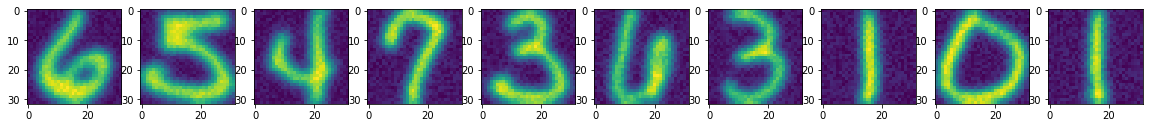

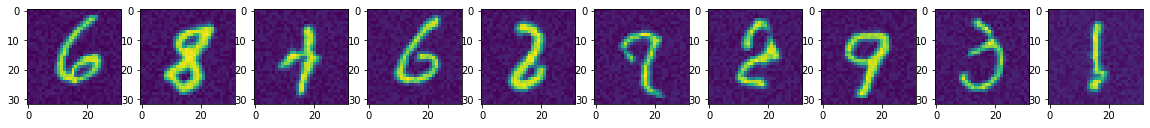

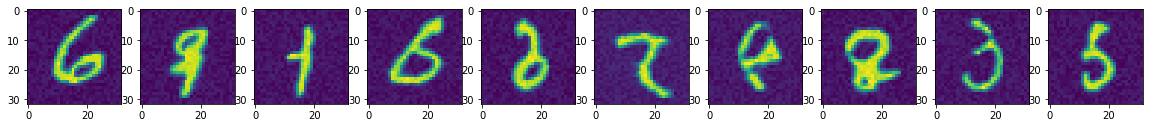

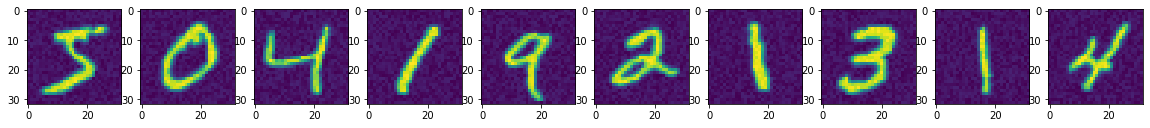

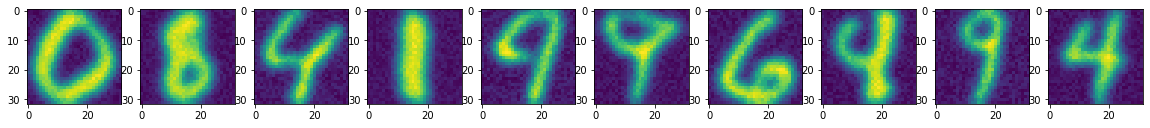

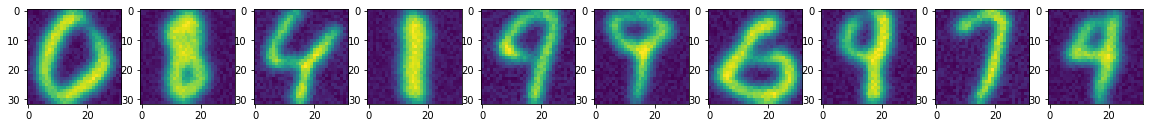

In [ ]:
show_panel(batch_b)
show_panel(model_t_fitted.bijector.forward(batch_b))
show_panel(model_t.bijector.forward(batch_b))

show_panel(batch_a)
show_panel(model_t_fitted.bijector.inverse(batch_a))
show_panel(model_t.bijector.inverse(batch_a))

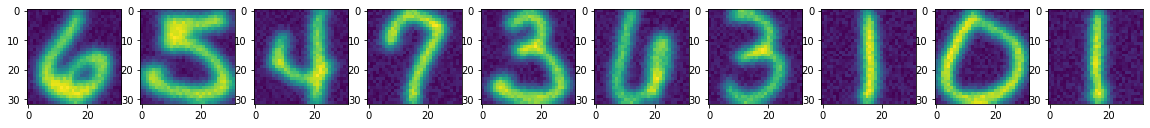

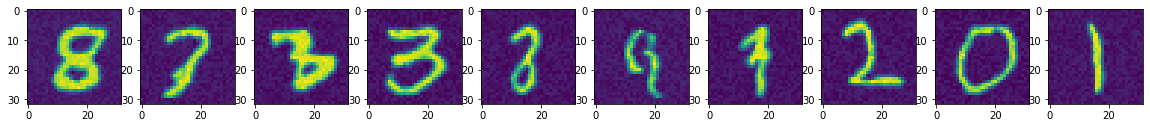

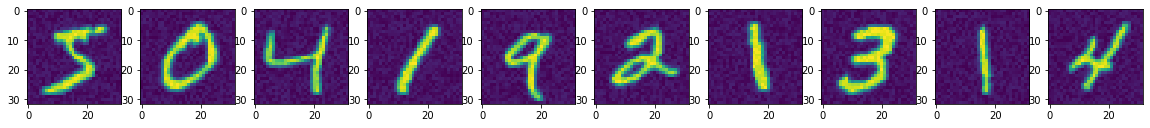

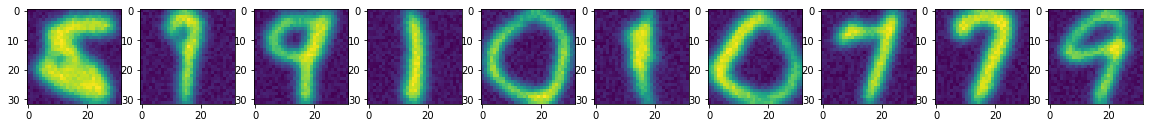

In [ ]:
batch_a = next(iter(mnist_dataset_aug.batch(16)))
batch_b = next(iter(usps_dataset_aug.batch(16)))
show_panel(batch_b)
show_panel(model_t.bijector.forward(batch_b))

show_panel(batch_a)
show_panel(model_t.bijector.inverse(batch_a))

In [ ]:
model_t_fitted = lrmf.build_glow_translation_model((32, 32, 1), levels=3, level_depth=8)

In [ ]:
print(model_t_fitted.bijector.bijectors[1].forward(mnist_array[:4]).shape)
print(model_t_fitted.bijector.bijectors[0].inverse(mnist_array[:4]).shape)
lrmf.ckpt_restore_latest('/scratch2/run/lrmf/actual_lrmf/digits_scr/ckpt', model_t=model_t_fitted)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Creating pad 1_1_18_18
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Creating pad 1_1_10_10
Creating pad 1_1_6_6
(4, 32, 32, 1)
(4, 32, 32, 1)
restoring ['model_t'] : /scratch2/run/lrmf/actual_lrmf/digits_scr/ckpt/ckpt-45


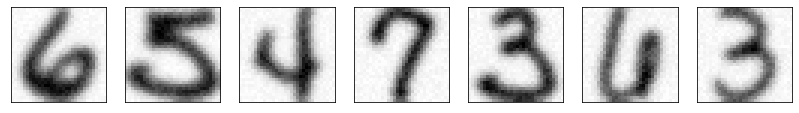

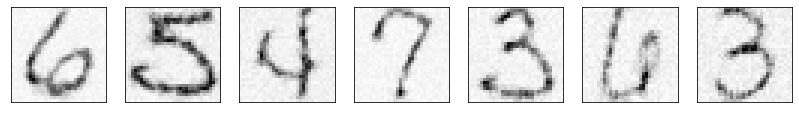

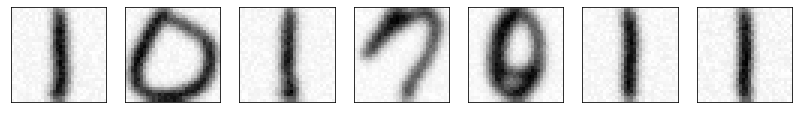

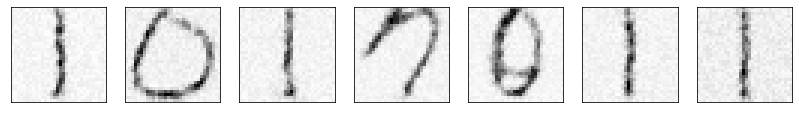

In [ ]:
batch_a = next(iter(mnist_dataset_aug.batch(16)))
batch_b = next(iter(usps_dataset_aug.batch(16)))
gen_b = model_t_fitted.bijector.forward(batch_b)
show_panel(batch_b[:7], n=7, cmap='Greys')
show_panel(gen_b[:7], n=7, cmap='Greys')

show_panel(batch_b[7:14], n=7, cmap='Greys')
show_panel(gen_b[7:14], n=7, cmap='Greys')

# show_panel(batch_a)
# show_panel(model_t.bijector.inverse(batch_a))

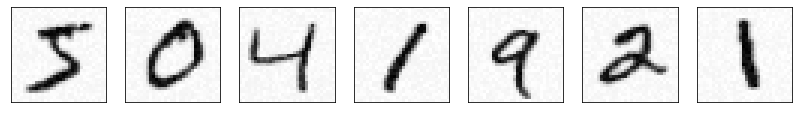

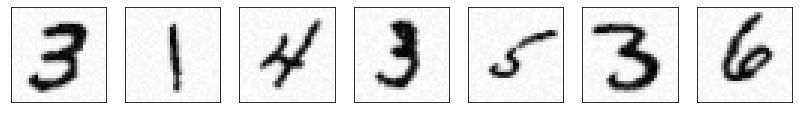

In [ ]:
show_panel(batch_a[:7], n=7, cmap='Greys')
show_panel(batch_a[7:14], n=7, cmap='Greys')

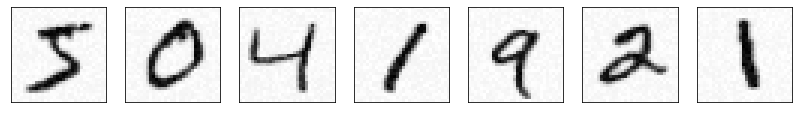

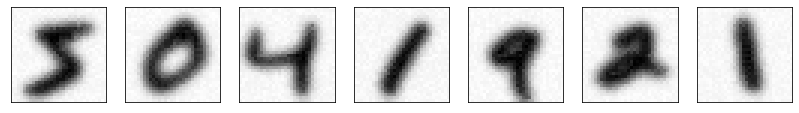

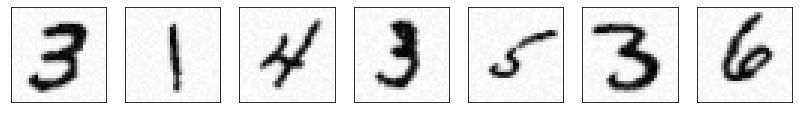

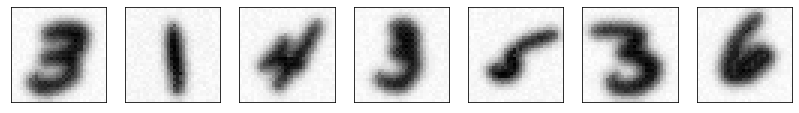

In [ ]:
gen_a = model_t_fitted.bijector.inverse(batch_a)
show_panel(batch_a[:7], n=7, cmap='Greys')
show_panel(gen_a[:7], n=7, cmap='Greys')

show_panel(batch_a[7:14], n=7, cmap='Greys')
show_panel(gen_a[7:14], n=7, cmap='Greys')

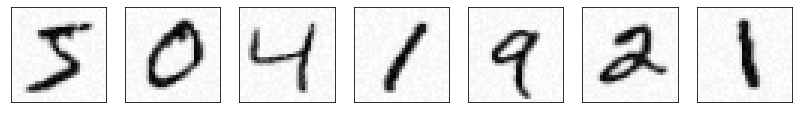

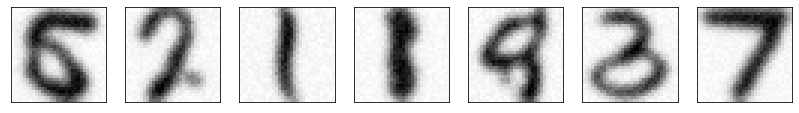

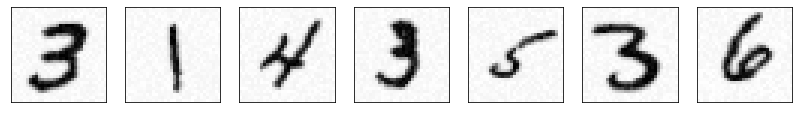

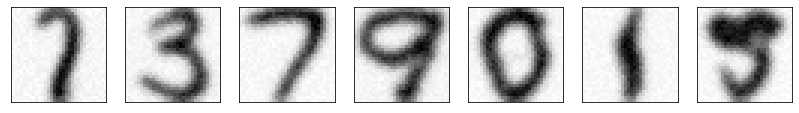

In [ ]:
gen_a = model_t.bijector.inverse(batch_a)
show_panel(batch_a[:7], n=7, cmap='Greys')
show_panel(gen_a[:7], n=7, cmap='Greys')

show_panel(batch_a[7:14], n=7, cmap='Greys')
show_panel(gen_a[7:14], n=7, cmap='Greys')